---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve,auc
import matplotlib.pyplot as plt
%matplotlib notebook

def blight_model():
    df_source = pd.read_csv('train.csv', encoding = 'ISO-8859-1')
    df_lookup = df_source[['ticket_id','compliance']]
    addresses = pd.read_csv('addresses.csv',encoding = 'ISO-8859-1')
    latlons = pd.read_csv('latlons.csv',encoding = 'ISO-8859-1')
    df_predict = pd.read_csv('test.csv',encoding = 'ISO-8859-1')
    
    df_source2 = df_source[['ticket_id','agency_name', 'inspector_name','ticket_issued_date','hearing_date', 'violation_code', 'fine_amount',
                       'admin_fee','state_fee', 'late_fee', 'discount_amount', 'judgment_amount']]
    df_source2['group'] = 'to_use_in_model'
    
    df_predict2 = df_predict[['ticket_id','agency_name', 'inspector_name','ticket_issued_date','hearing_date', 'violation_code', 'fine_amount',
                       'admin_fee','state_fee', 'late_fee', 'discount_amount', 'judgment_amount']]
    df_predict2['group'] = 'to_be_predicted'
    
    #both the dataset with labels (To be used for modelling) and the one without (to be predicted) are merged for all feature engineering tasks
    df_total = pd.concat([df_source2, df_predict2])
    #############OBTAINING LATITUD AND LONGITUDE PARAMS THROUGH MERGE###########################
    df_total = pd.merge(df_total, addresses, right_on='ticket_id', left_on='ticket_id', how='left')
    df_total = pd.merge(df_total, latlons, right_on='address', left_on = 'address', how='left') 
    df_total = df_total.replace(r'^\s+$', np.nan, regex=True)

    #############EXTRACTING RELEVANT FEATURES OUT OF DATE FIELDS###########################
    df_total['hearing_date_'] = df_total['hearing_date'].apply(lambda x: np.nan if pd.isnull(x) else datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))
    df_total['ticket_issued_date_'] = df_total['ticket_issued_date'].apply(lambda x: np.nan if pd.isnull(x) else datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))
    df_total['time_to_hearing'] = df_total[['hearing_date_','ticket_issued_date_']].apply(lambda x: np.nan if pd.isnull(x['hearing_date_']) else (np.nan if pd.isnull(x['ticket_issued_date_']) else (x['hearing_date_'] - x['ticket_issued_date_']).days), axis=1)     
    df_total['year_hearing'] = df_total['hearing_date_'].apply(lambda x: np.nan if pd.isnull(x) else x.year)
    df_total['month_hearing'] = df_total['hearing_date_'].apply(lambda x: np.nan if pd.isnull(x) else x.month)
    df_total['year_issue'] = df_total['ticket_issued_date_'].apply(lambda x: np.nan if pd.isnull(x) else x.year)
    df_total['month_issue'] = df_total['ticket_issued_date_'].apply(lambda x: np.nan if pd.isnull(x) else x.month)
    
    ############FEATURE EXTRACTION FINISHED - GROUPS TO BE SEPARATED FOR TREATMENT##########
    df_source2 = df_total[df_total['group'] == 'to_use_in_model']
    df_predict2 = df_total[df_total['group'] == 'to_be_predicted']

    df_predict2 = df_predict2[['late_fee','time_to_hearing','lon','lat','year_hearing','month_hearing','year_issue','month_issue',
                      'fine_amount','discount_amount']]
 
    df_source2 = pd.merge(df_source2, df_lookup, right_on='ticket_id', left_on='ticket_id',how='left')
    df_source2 = df_source2[['late_fee','time_to_hearing','lon','lat','year_hearing','month_hearing','year_issue','month_issue',
                      'fine_amount','discount_amount','compliance']]
    df_source2  = df_source2[~np.isnan(df_source2['compliance'])]
    df_source2 = df_source2[df_source2['year_issue']> 2004]
    df_source2 = df_source2[df_source2['time_to_hearing'] >= 0]

    #removing na values, separately to avoid data leakage
    df_source2.fillna(df_source2.mean(), inplace=True)
    df_predict2.fillna(df_predict2.mean(),inplace=True)
    
    #############SETTING UP A MACHINE LEARNING MODEL########################################
    y = df_source2.iloc[:,-1]
    X = df_source2.iloc[:,:-1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    ##OPTIMIZING THE PARAMETERS. LINES COMMENTED ONCE KEY INSIGHTS WERE EXTRACTED TO SPEED UP EXECUTION
    #print('------------we get to the optimization phase------------------')
    #clf2 = GradientBoostingClassifier(random_state=0)
    #grid_values = {'n_estimators':[150,200],'learning_rate':[0.2,0.3,0.4] }
    #grid_clf_auc = GridSearchCV(clf2, param_grid = grid_values, scoring='roc_auc')
    #grid_clf_auc.fit(X_train, y_train, sample_weights)
    #print('Grid best parameter (max. roc_auc): ', grid_clf_auc.best_params_)
    #print('Grid best score (roc_auc): ', grid_clf_auc.best_score_)
    
    ###FITTING THE FINAL CLASSIFIER TO CHECK OVERALL AUC AND LOOK AT THE FEATURE SELECTION
    clf = GradientBoostingClassifier(random_state=0, n_estimators=200, learning_rate = 0.2).fit(X_train, y_train,sample_weights)
    y_predict = clf.predict(X_test)
    print('Accuracy Score: ', accuracy_score(y_test, y_predict))
    print('Precision Score: ', precision_score(y_test,y_predict))
    print('Recall Score: ', recall_score(y_test,y_predict))
    print('AUC Score: ', roc_auc_score(y_test, y_predict))
    
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_predict)
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    plt.figure()
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve (Compliance prediction for blight tickets)', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()

    
    feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)
    
    ###as the last step, we calculate the probability of the positive label, for the dataset without it########
    ticket_ids = df_predict['ticket_id'].values
    probs = clf.predict_proba(df_predict2.iloc[:,:])
    return pd.Series(probs[:,1], ticket_ids)

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2827: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Accuracy Score:  0.833893206317
Precision Score:  0.237798976911
Recall Score:  0.607130250618
AUC Score:  0.729179719043


<IPython.core.display.Javascript object>


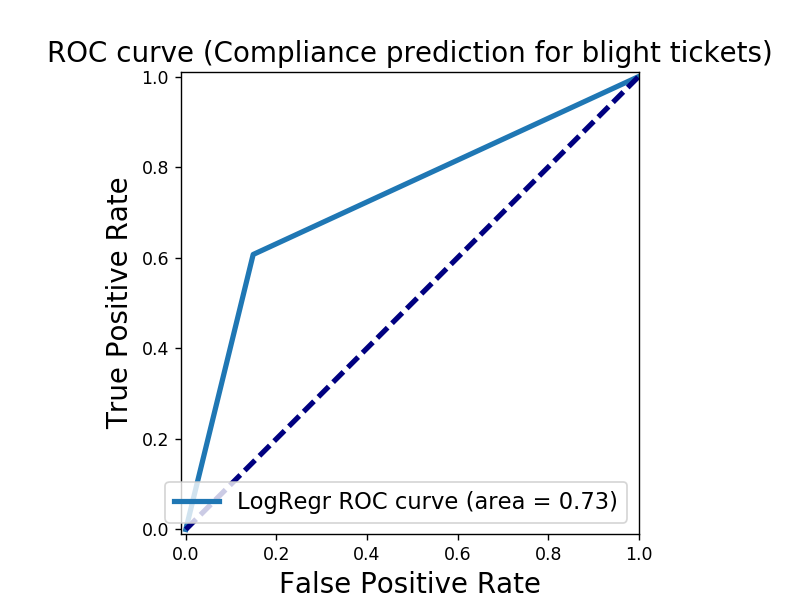

                 importance
lon                0.267372
lat                0.237081
time_to_hearing    0.124550
late_fee           0.122794
year_hearing       0.058039
month_hearing      0.050315
fine_amount        0.047917
year_issue         0.045649
month_issue        0.032317
discount_amount    0.013967


284932    0.584759
285362    0.106811
285361    0.532530
285338    0.663347
285346    0.715916
285345    0.710988
285347    0.704141
285342    0.923529
285530    0.123737
284989    0.409001
285344    0.726515
285343    0.295786
285340    0.364853
285341    0.797957
285349    0.773243
285348    0.768988
284991    0.409001
285532    0.216779
285406    0.288938
285001    0.600341
285006    0.680040
285405    0.120922
285337    0.197840
285496    0.772911
285497    0.780763
285378    0.129446
285589    0.258406
285585    0.434555
285501    0.782203
285581    0.115495
            ...   
376367    0.288584
376366    0.402547
376362    0.596272
376363    0.786113
376365    0.288584
376364    0.402547
376228    0.671928
376265    0.291032
376286    0.892687
376320    0.555525
376314    0.421963
376327    0.947054
376385    0.927500
376435    0.926347
376370    0.933450
376434    0.702573
376459    0.720326
376478    0.024274
376473    0.562756
376484    0.369370
376482    0.516394
376480    0.

In [7]:
blight_model()